In [1]:
import sys
sys.path.append("../")
from utils import transform_image_to_kspace, transform_kspace_to_image
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import pydicom
from scipy import ndimage
from scipy import interpolate

#import warnings
#warnings.filterwarnings("ignore")

In [2]:
data_path = r'C:\from SSD\fastMRI_brain_DICOM\100099070170\279.dcm'
#data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\300008311232\808.dcm'
#data_path = r"C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis\Pelvis_2233,MP Pelvis_2233,MP\CT.2.25.168430369902691384448665480955143203741.dcm"

data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

In [15]:
def BiasGenerator(size,
                  batch_size=None,
                  bias_range=None,
                  freq=None):
    """A generator of bias fields of specified size and parameters.
    The images are organised in a directory for each image, a subdirectory
    for each channel, and the third-dimension slices for each channel are
    in those subdirectories.
    It will be assumed that the subdirectories (channels) of the given
    directory (image) contains different "channels" (different image modes,
    for instance), and they will be returned as such. The subdirectories and
    their order is determined by the list ``channel_names``.
    Parameters
    ----------
    batch_size : int or None, optional
        The number of images to return at each yield. If None, all images will
        be returned. If there are not enough images to return in one batch, the
        source directory is considered exhausted, and StopIteration will be
        thrown. Default is 1, which means to return only one image at the time.
    size : array of int, length 2, optional
        The (possibly cropped image) will be resized to this absolute size.
        Default is None, do not resize the images. See also
        ``keep_aspect_ratio`` and ``minimum_size``.
    
    lbias_range: int, optional
        The range of the bias field. N4 experiments use the following:
        0.2 (20%) for [0.9 1.1] and 0.4 (40%) [0.8 1.2].
        
    freq: float
        In the range of [0 1] it sets 
    Examples
    --------
    >>> import numpy as np
    >>> from nethin.data import DicomGenerator
    """
    
    random_bias = 0
    
    if len(size)==2:
        size[0] = int(size[0])
        size[1] = int(size[1])
    elif len(size)==1:
        size = [int(size[0]), int(size[0])]
    else:
        raise RuntimeError("Check the input size of the bias field.")
        
    if batch_size is None:
        batch_size = 1
    else:
        batch_size = max(1, int(batch_size))
    
    if freq is None:
        freq = 0
        
    if bias_range is None:
        # Do Random between [0.1 0.4]
        # Works great for training set.
        random_bias = 1
        #bias_range = 0.2
    
    grid_x, grid_y = np.mgrid[0:size[0]:1, 0:size[1]:1]
    num_points = np.random.randint(198*freq+2,298*freq+8)
    print(num_points)
    BiasFields = np.zeros((size[0], size[1],batch_size))
    for image_i in range(batch_size):
        if random_bias:
            bias_range = np.random.uniform(0.2, 0.4)
        z = np.random.uniform(size=num_points)
        points = np.transpose(np.random.uniform(size=(2,num_points)))
        points[:,0] = points[:,0]*size[0]*1.2 - size[0]*0.1
        points[:,1] = points[:,1]*size[1]*1.2 - size[1]*0.1
        grid_z = interpolate.griddata(points, z, (grid_x, grid_y), method='nearest', fill_value=0)
        grid_z = ndimage.gaussian_filter(grid_z, sigma=size[0]/(freq*3+2), order=0)
        grid_z = np.interp(grid_z, (grid_z.min(), grid_z.max()), (1-bias_range/2, 1+bias_range/2))
        BiasFields[:,:,image_i]= grid_z

    return BiasFields

3
252


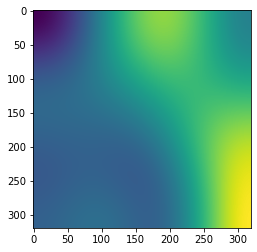

In [20]:
im_size = [320, 320]
full_bias = BiasGenerator(size = im_size, batch_size=None, freq=0, bias_range = 0.4)
HighBiasFields = BiasGenerator(size = im_size, batch_size=None, freq=1, bias_range = 0.4)    
full_bias2 = np.multiply(full_bias, HighBiasFields)
bias = np.squeeze(full_bias2)
img = np.multiply(image, bias)
img = (img - np.mean(img)) / np.std(img)
plt.imshow(np.squeeze(full_bias2))

In [6]:
print(np.min(image), np.mean(image), np.std(image), np.max(image))
print(np.min(img), np.mean(img), np.std(img), np.max(img))

-0.8580642090420407 2.2204460492503132e-17 1.0 7.198928552992595
-1.0015850284356709 1.3322676295501878e-17 0.9999999999999998 8.004599634008315


In [88]:
from sklearn.metrics import mean_squared_error
mean_squared_error(image, img)

0.05544054102706353

In [8]:

# im_size = [512, 512]
# im_list = os.listdir('/mnt/f4616a95-e470-4c0f-a21e-a75a8d283b9e/RAW/ImageNet/48000/')
# mat = scipy.io.loadmat('dataset.mat')
# images = mat['ImageCollection'].astype('float32') / 255
# im_size = [np.shape(images)[0], np.shape(images)[1]]
# file_id = 0
# gen_size = 3
# X = np.arange(im_size[0])
# Y = np.arange(im_size[1])
# X, Y = np.meshgrid(X, Y)

# for im_i in range(np.shape(images)[2]):
#     dataset = np.repeat(np.expand_dims(images[:,:,im_i], axis=2), gen_size, axis=2)
    
#     full_bias = BiasGenerator(size = im_size, batch_size=gen_size, freq=0, bias_range = 0.4)
#     HighBiasFields = BiasGenerator(size = im_size, batch_size=gen_size, freq=1, bias_range = 0.4)    
#     full_bias = np.multiply(full_bias, HighBiasFields)
    
#     noise = np.random.uniform(0,size=np.shape(dataset)) *0.01*np.max(dataset)
#     full_data = np.multiply(dataset, full_bias) + noise

#     for bias_i in range(gen_size):
#         current_bias = full_bias[:,:,bias_i]
#         current_image = full_data[:,:,bias_i]
#         current_data = dataset[:,:,bias_i]
#         current_image = np.array(np.interp(current_image, (current_image.min(), current_image.max()), (0, 255)), dtype=np.uint8)
#         #current_bias = np.array(np.interp(current_bias, (current_bias.min(), current_bias.max()), (0, 255)), dtype=np.uint8)
#         current_data = np.array(np.interp(current_data, (current_data.min(), current_data.max()), (0, 255)), dtype=np.uint8)
# #        plt.figure(file_id)
# #        plt.subplot(1,3,1)
# #        plt.imshow(current_bias)
# #        plt.colorbar()
# #        plt.subplot(1,3,2)
# #        plt.imshow(current_image)
# #        plt.colorbar()
# #        plt.subplot(1,3,3)
# #        plt.imshow(current_data)
# #        plt.colorbar()
# #        plt.show()
#         np.savez('/mnt/4a39cb60-7f1f-4651-81cb-029245d590eb/DS0043v/training/' + str(file_id), image = current_image, data = current_data)
#         file_id+=1

(-0.5, 319.5, 319.5, -0.5)

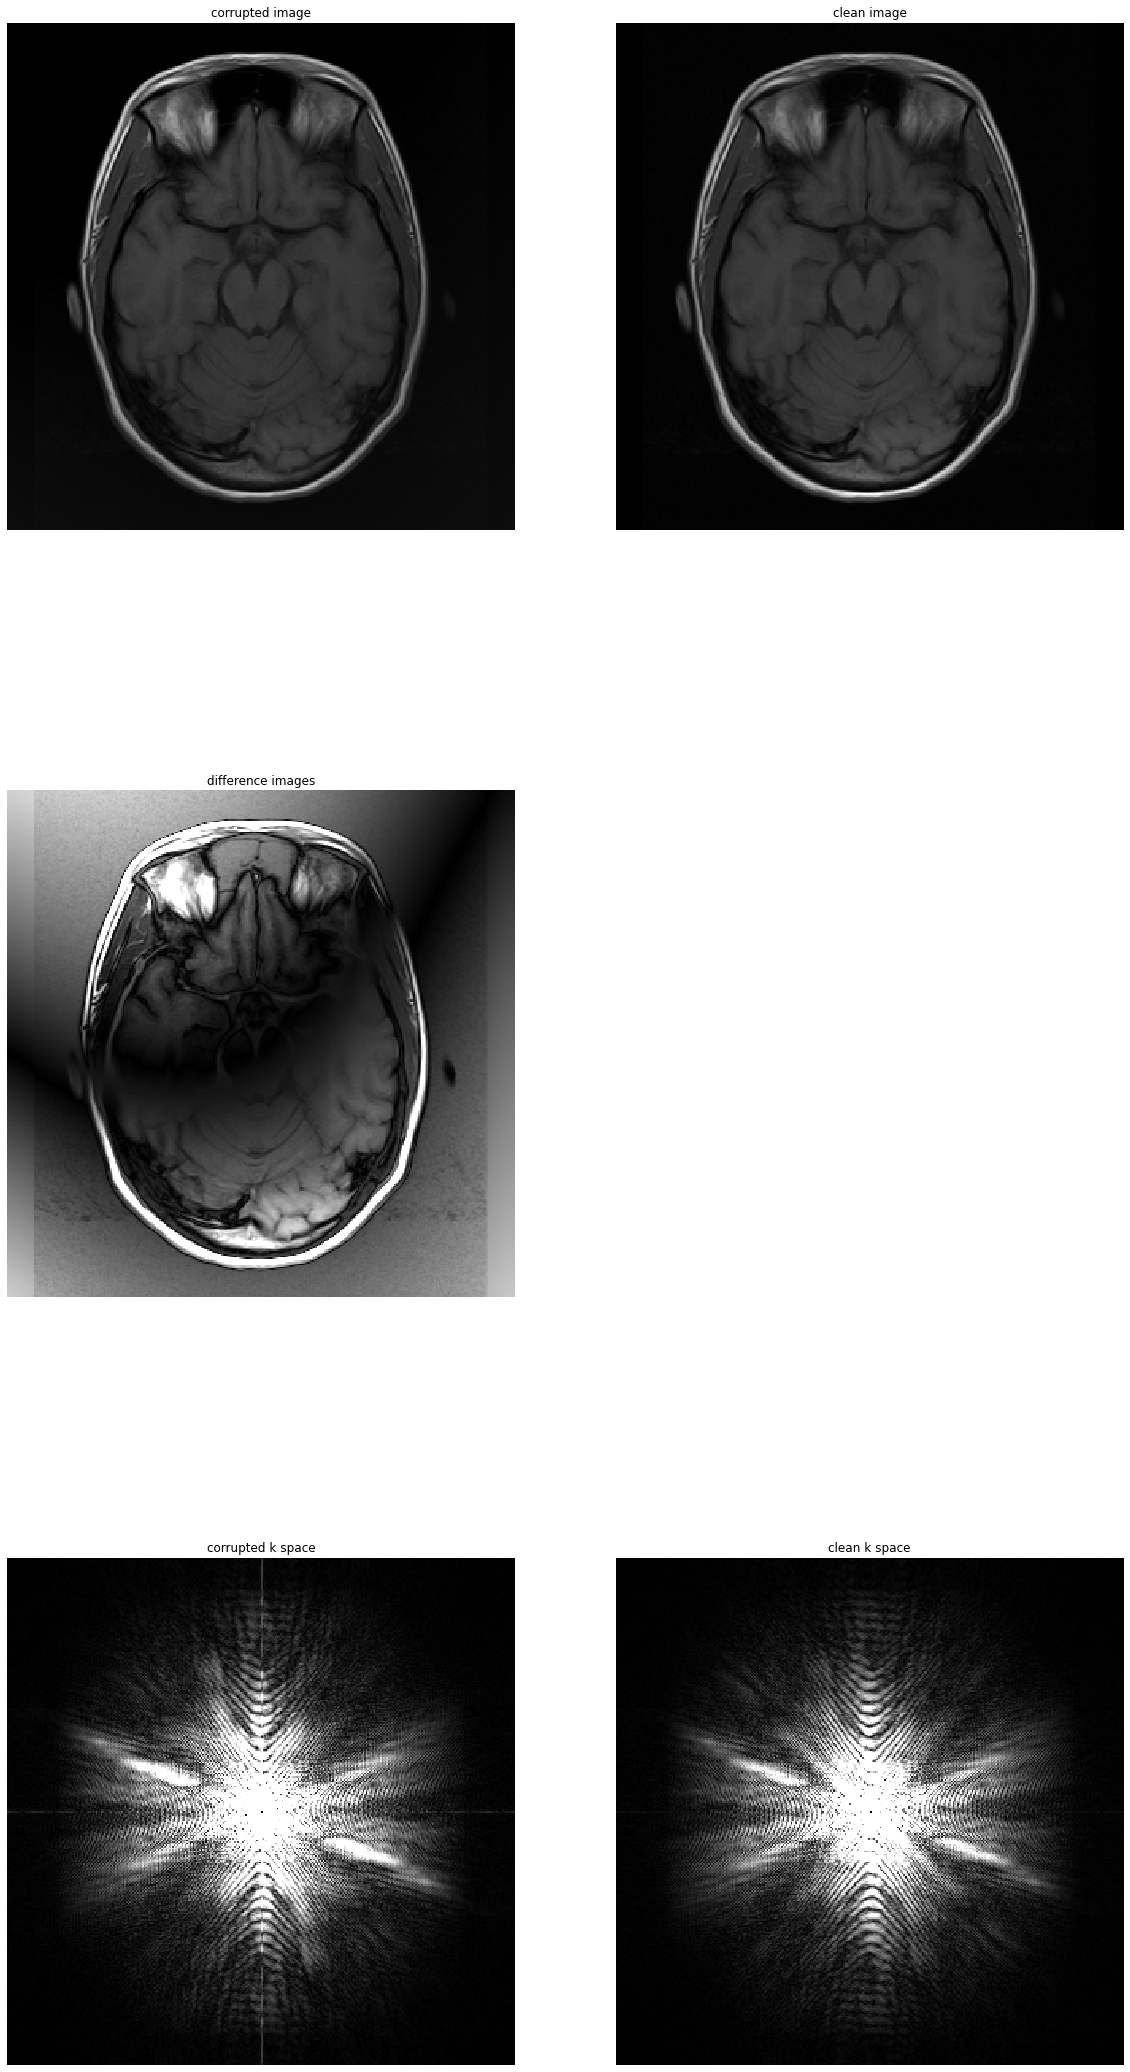

In [87]:
# plotting

hr = image
lr = img

k_lr = np.abs(transform_image_to_kspace(lr))
k_hr = np.abs(transform_image_to_kspace(hr))

k_lr = k_lr / np.max(np.abs(k_lr))
k_hr = k_hr / np.max(np.abs(k_hr))

lr = (lr - np.mean(lr)) / np.std(lr)
hr = (hr - np.mean(hr)) / np.std(hr)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(lr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("corrupted image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 2)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("clean image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 3)
ax.imshow(np.abs(lr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.set_title("difference images")
ax.axis('off')
ax = fig.add_subplot(3, 2, 5)
ax.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("corrupted k space")
ax.axis('off')
ax = fig.add_subplot(3, 2, 6)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("clean k space")
ax.axis('off')

In [83]:
class BiasGenerator(object):
    ######################################################################
    # 2D DCT

    def dct2(self, y):
        from scipy.fftpack import dct, idct
        M = y.shape[0]
        N = y.shape[1]
        a = np.empty([M,M],float)
        b = np.empty([M,M],float)

        for i in range(M):
            a[i,:] = dct(y[i,:], norm='ortho')
        for j in range(N):
            b[:,j] = dct(a[:,j], norm='ortho')

        b = b[:M, :N]

        m = b.shape[0]
        n = b.shape[1]
        M = 320
        N = 320
        a = np.empty([m,N],float)
        y = np.empty([M,N],float)

        for i in range(m):
            a[i,:] = idct(b[i,:], n=M, norm='ortho')
        for j in range(N):
            y[:,j] = idct(a[:,j], n=N, norm='ortho')
        return y

    def __init__(self,
                 size,
                 batch_size):
        """A generator of bias fields of specified size and parameters.
        Parameters
        ----------
        batch_size : int or None, optional
        The number of images to return at each yield. If None, all images will
        be returned. If there are not enough images to return in one batch, the
        source directory is considered exhausted, and StopIteration will be
        thrown. Default is 1, which means to return only one image at the time.
        size : array of int, length 2, optional
            The (possibly cropped image) will be resized to this absolute size.
            Default is None, do not resize the images. See also
            ``keep_aspect_ratio`` and ``minimum_size``.
        lbias_range: int, optional
            The range of the bias field. N4 experiments use the following:
            0.2 (20%) for [0.9 1.1] and 0.4 (40%) [0.8 1.2].
        freq: float
            In the range of [0 1] it sets
        Examples
        --------
        >>> import numpy as np
        >>> from MLTK.data import DicomGenerator
        """

        random_bias = 0
        self.size = size
        self.down_size = np.int32(np.divide(size, 10))
        self.len_scale = self.down_size / np.random.uniform(0.5, 2)
        self.batch_size = batch_size
        self.dims = len(size)

    def GetFields(self):
        from gstools import SRF, Gaussian
        BiasFields = np.zeros(self.size + (self.batch_size,))
        #ind = [slice(None)]*(len(self.size)+1)
        x = np.arange(self.down_size[0])
        y = np.arange(self.down_size[1])

        for image_i in range(self.batch_size):
            #bias_rng = np.random.uniform(0.10, 0.50)
            bias_rng = 1
            #ind[-1] = image_i
            model = Gaussian(dim=2, var=50, len_scale=self.len_scale)

            srf = SRF(model)

            grid_z = srf((x, y), mesh_type='structured')
            grid_z = self.dct2(grid_z)
            print(grid_z.min(), grid_z.max())
            grid_z = np.interp(grid_z, (grid_z.min(), grid_z.max()),
                               (1 - bias_rng / 2, 1 + bias_rng / 2))
            #BiasFields[ind] = grid_z
            print(grid_z.min(), grid_z.max())

        #return BiasFields
        return grid_z

In [76]:
bias_rng = 0.50 #np.random.uniform(0.10, 0.50)
print(1 - bias_rng / 2, 1 + bias_rng / 2)

0.75 1.25


-1.4671964397152968 -0.39436611014588413
0.5 1.5


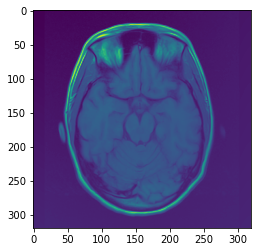

In [84]:
bias_generator = BiasGenerator(image.shape, 1)
bias = bias_generator.GetFields()
bias = np.squeeze(bias)
img = np.multiply(image, bias)
img = (img - np.mean(img)) / np.std(img)
plt.imshow(img)

In [85]:
np.min(bias), np.mean(bias), np.std(bias), np.max(bias)

(0.5, 0.9840386904527595, 0.23577877093527644, 1.5)

In [52]:
down_size = np.int32(np.divide(image.shape, 10))
len_scale = down_size / np.random.uniform(0.5, 2)
len_scale

array([16.6695033, 16.6695033])

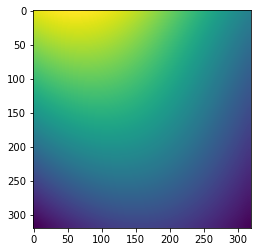

In [86]:
plt.imshow(bias)